<a href="https://colab.research.google.com/github/HXY1029/DSS5104_GrpPrj/blob/main/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#load the data energy_processed
import pandas as pd
file_path = '/content/drive/MyDrive/group/GOOGL_standardized.csv'
df = pd.read_csv(file_path)
df


In [4]:
df.columns


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'log_return',
       'price_change', 'MA_5', 'MA_10', 'volatility_5', 'volatility_10',
       'dayofweek', 'is_month_end', 'target_regression', 'target_direction',
       'log_return_standardized', 'price_change_standardized',
       'MA_5_standardized', 'MA_10_standardized', 'volatility_5_standardized',
       'volatility_10_standardized', 'target_regression_standardized'],
      dtype='object')

X_train shape: (974, 28, 6)
y_train shape: (974,)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.1326 - mae: 0.3192 - val_loss: 0.1637 - val_mae: 0.3857
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0662 - mae: 0.2311 - val_loss: 0.0185 - val_mae: 0.1238
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0129 - mae: 0.0942 - val_loss: 0.0095 - val_mae: 0.0821
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0208 - mae: 0.1223 - val_loss: 0.0078 - val_mae: 0.0786
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0059 - mae: 0.0639 - val_loss: 0.0016 - val_mae: 0.0341
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0090 - mae: 0.0779 - val_loss: 0.0041 - val_mae: 0.0563
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0033 - mae: 0.0451 - val_loss: 0.0016 - val_mae: 0.0309
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0043 - mae: 0.0524 - val_loss: 0.0060 - val_mae: 0.0698
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0033 - mae:

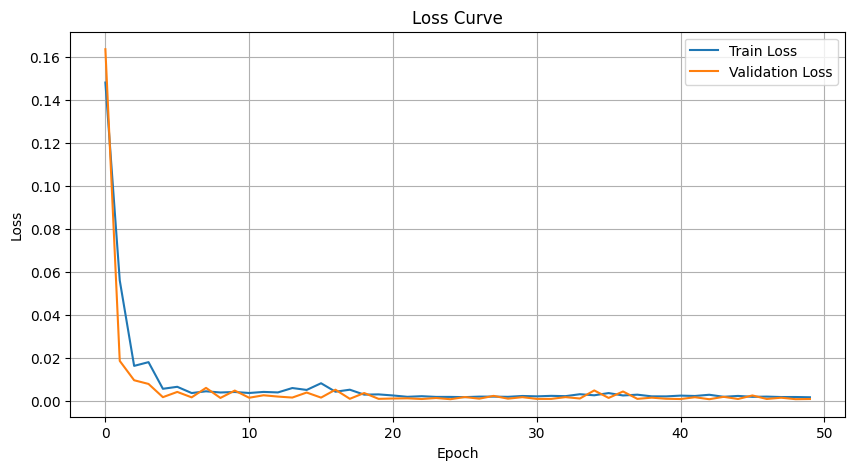

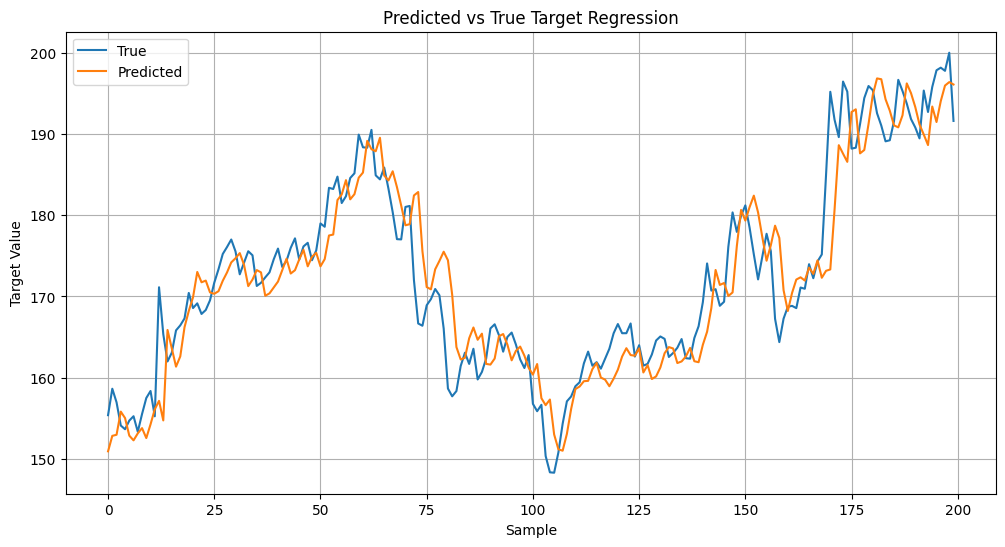

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ----------------------------
# 1. 数据加载与预处理

df = df.dropna()

# 特征与目标
features = ['log_return_standardized', 'price_change_standardized',
            'MA_5_standardized', 'MA_10_standardized',
            'volatility_5_standardized', 'volatility_10_standardized']
target_raw = 'target_regression'  # 原始回归目标
target_scaled = 'target_regression_standardized'  # 标准化后目标

# 特征和目标提取
X = df[features].values
y = df[target_raw].values.reshape(-1, 1)  # 使用原始值进行 MinMaxScaler 缩放，方便还原

# 目标归一化（便于反归一化）
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y).flatten()

# 构造序列样本
def create_sequences(X, y, seq_len=28):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# ----------------------------
# 2. 模型构建与训练
# ----------------------------
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    shuffle=False
)

# ----------------------------
# 3. 模型评估与预测
# ----------------------------
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE (scaled): {mae:.4f}")

y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# ----------------------------
# 4. 可视化
# ----------------------------

# Loss 曲线
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 预测 vs 真实
plt.figure(figsize=(12, 6))
plt.plot(y_true[:200], label='True')
plt.plot(y_pred[:200], label='Predicted')
plt.title('Predicted vs True Target Regression')
plt.xlabel('Sample')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()
